In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory, load_stuff
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data_dir = create_directory(directory_name='loss20')
#from model import train
#train(model_num=0,phase='growing_up',n_batch=10010,directory_name='try_mdy1')

97.94136165067887
27.51371779293484
1.5102058326138392
4.985866838349236
2.201984674308035
0.0027474288950260313
0.0180448504694634
0.0
1.6057204616268475
-0.0007967444556545362


/Users/mahdiyarshahbazi/miniconda3/envs/dl/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


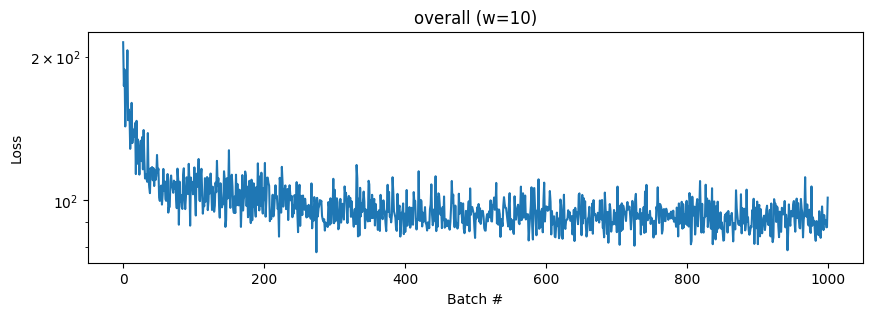

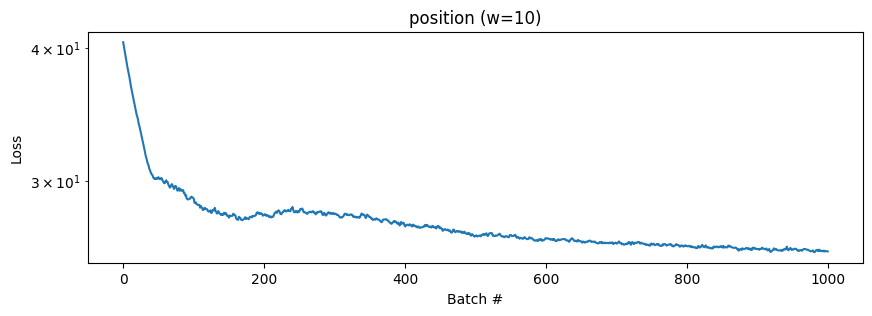

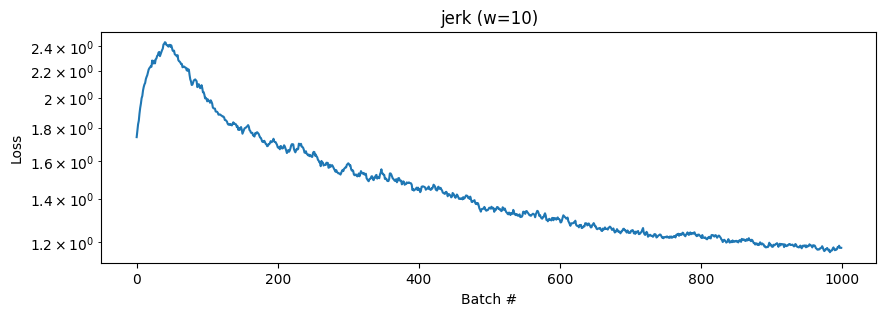

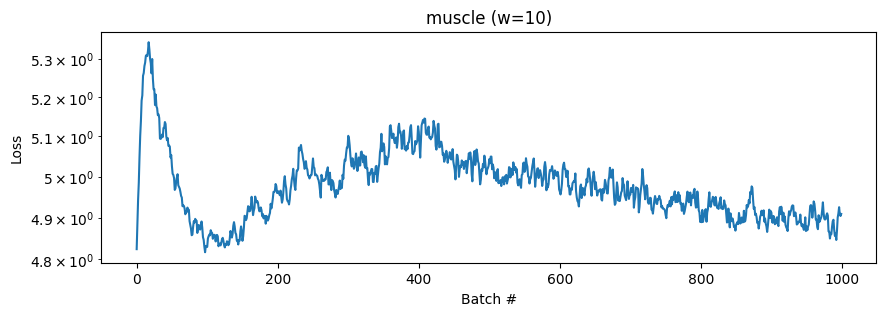

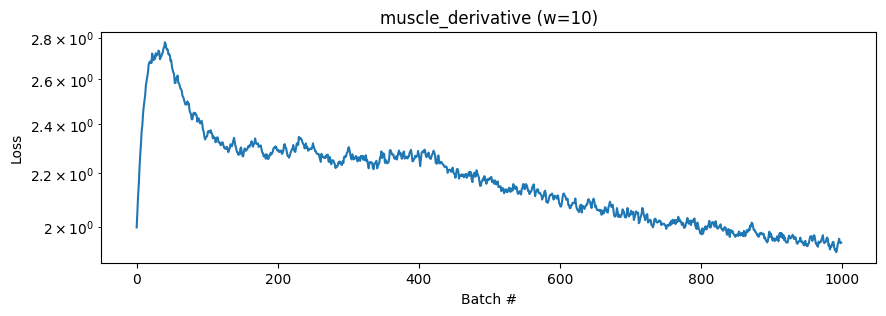

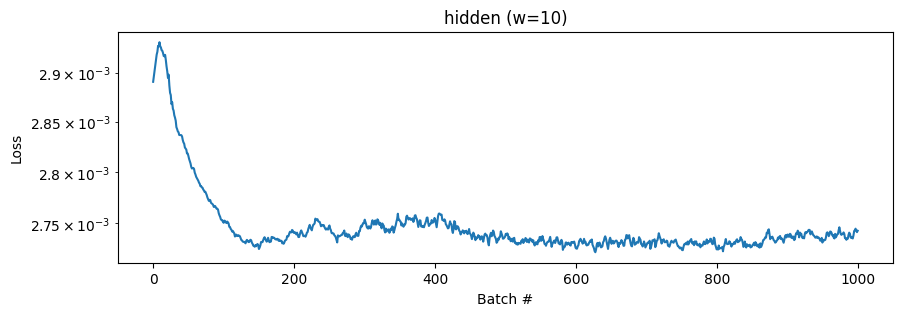

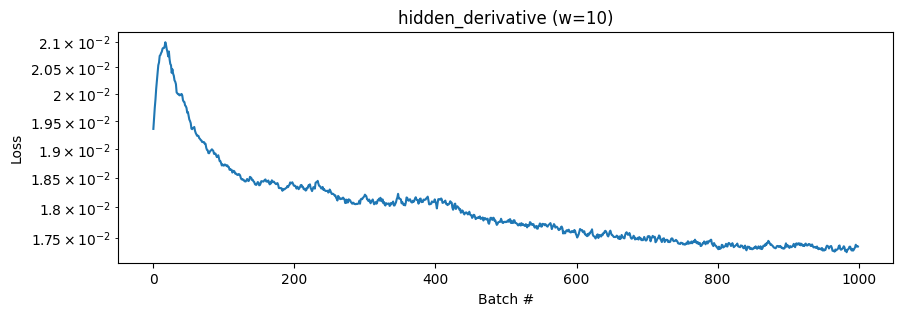

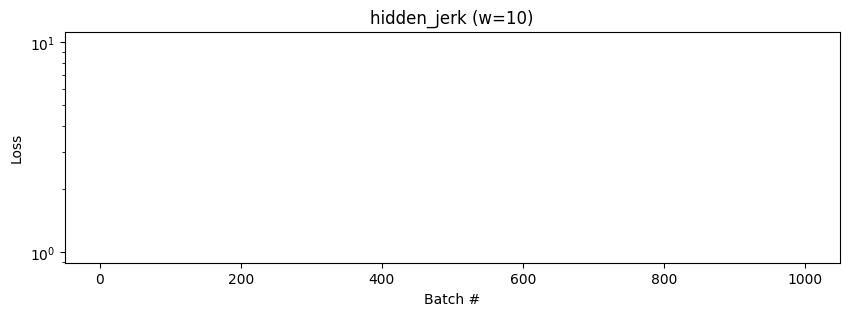

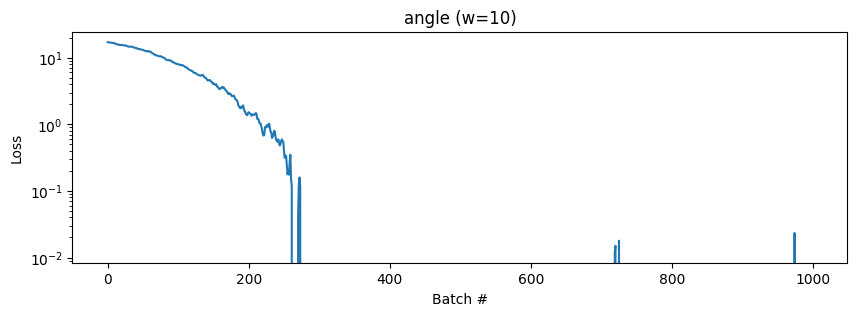

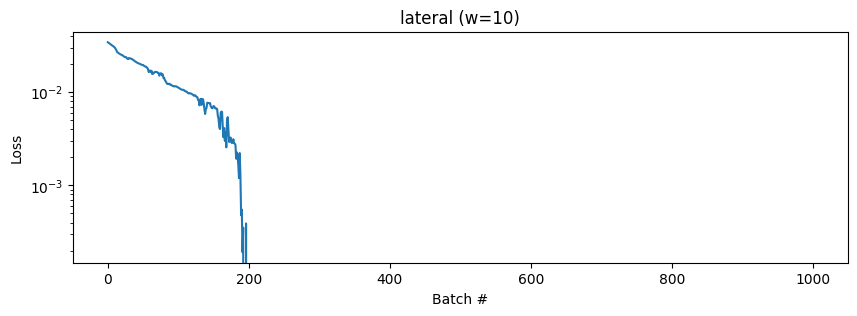

In [6]:
model_num = 0
# 12 13 (15 longer simulation time) 24 25 (26 great)
model_name = "model{:02d}".format(model_num)

phase = 'FF1'
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
log = json.load(open(log_file,'r'))
w=10
for loss in log.keys():
    fig,ax = plot.plot_training_log(log=log,loss_type=loss, w=w)
    ax.set_title(f"{loss} (w={w})")
#fig.savefig(os.path.join(data_dir,'loss_FF1.png'),dpi=300)
    
#fig, ax = plot.plot_learning(data_dir,num_model=16,w=1,phases=['growing_up'],loss_type='position',figsize=(7,4),ignore=[])
#ax[0].set_xlim([2000,10000])
#ax[0].set_ylim([-0.001,0.001])
#ax[0].set_yscale('log')

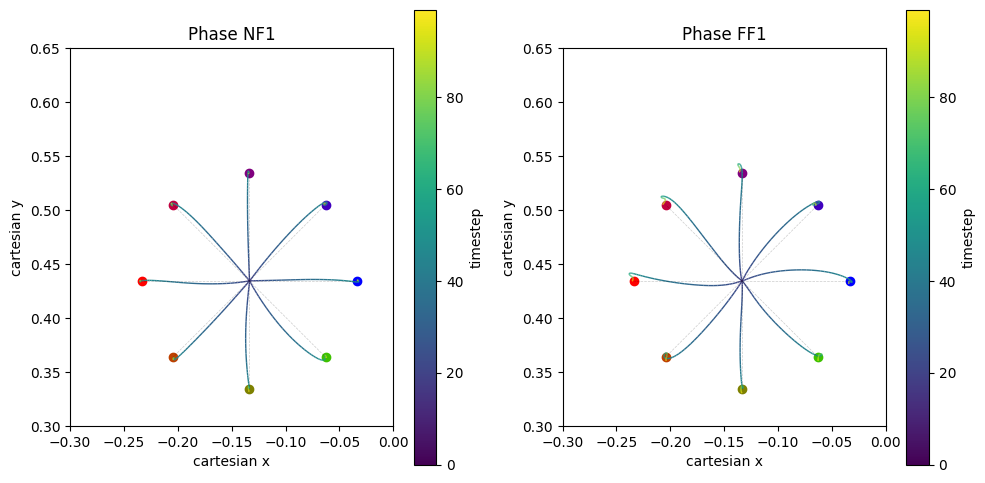

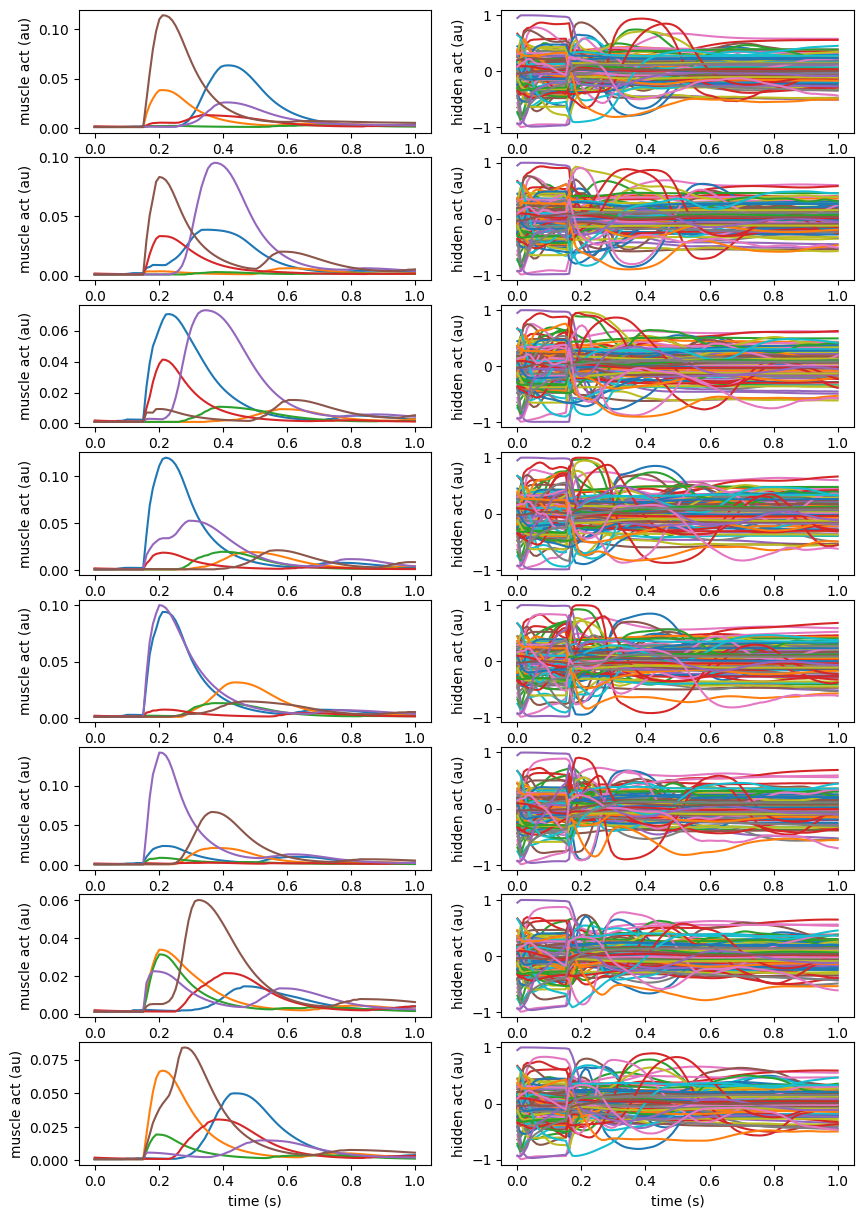

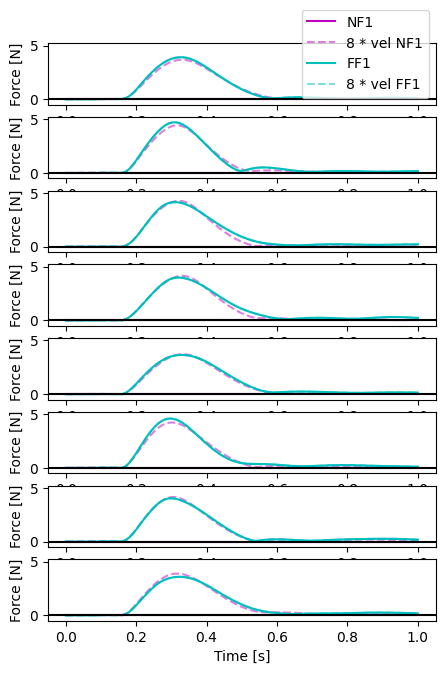

In [14]:
model_num = 0
for j in range(1):
    model_name = "model{:02d}".format(j)

    data = []
    #label = ['NF1','FF1']
    label = ['NF1','FF1']
    ff = [0,8]
    is_channel = False


    fig,ax = plt.subplots(1,len(label),figsize=(5*len(label),5))
    if len(label) == 1:
        ax = [ax]
        
    for i,p in enumerate(label):
        weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
        cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]

        env, policy, _, _ = load_stuff(cfg_file,weight_file,phase=p)
        data0, loss, ang_dev, lat_dev = test(env,policy,ff_coefficient=ff[i],is_channel=is_channel)
        data.append(data0)
        plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
        ax[i].set_title(f'Phase {p}')

    plt.tight_layout()
    plt.show()
    #fig.savefig(os.path.join(data_dir,f'{model_name}_trajectory.png'),dpi=300)

    fig, ax = plot.plot_activation(data[i]['all_hidden'],data[i]['all_muscle'],figsize=(10,15))
    #fig.savefig(os.path.join(data_dir,f'{model_name}_activation.png'),dpi=300)

    fig, ax = plot.plot_force(data,label,figsize=(5,7.5))
    #fig.savefig(os.path.join(data_dir,f'{model_name}_lateralforce.png'),dpi=300)

In [ ]:
fig, ax = plot.plot_force(data,label,figsize=(5,7.5))


In [ ]:
i = 0
fig, ax = plot.plot_kinematic(data[i]['vel'],data[i]['xy'],data[i]['tg'],figsize=(10,7.5)) # data[i]['vel']
#fig.savefig(os.path.join(data_dir,'kinematic.png'),dpi=300)

In [ ]:
fig, ax = plot.plot_force(data,label,figsize=(5,7.5))
#fig.savefig(os.path.join(data_dir,'lat_force.png'),dpi=300)

In [ ]:
fg, ax = plot.plot_epforce(data,label,figsize=(5,15))